In [1]:
# Cell 1: Import Required Libraries
# Purpose: Importing packages for resampling methods and visualization
# Dependencies: imblearn, sklearn, resampling_utils from src/
# ============================================================================

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# Adding src directory to path
sys.path.append('../src')

# Importing custom utilities
from config import *
from data_utils import retrieve_processed_datasets
from resampling_utils import (
    initialize_resampling_methods,
    apply_resampling_technique,
    save_resampled_dataset,
    compute_resampling_statistics
)
from visualization import plot_class_distribution

# Setting visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("All libraries imported successfully!")
print(f"Working Directory: {Path.cwd()}")
print(f"Random Seed: {SEED_VALUE}")

All libraries imported successfully!
Working Directory: C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\notebooks
Random Seed: 42


In [3]:
# Cell 2: Loading Training Data Only
# Loading only training data for resampling (test data is untouched)
# Remember to never apply resampling to test data

print("="*70)
print("LOADING TRAINING DATA FOR RESAMPLING")
print("="*70)

# Loading processed datasets
X_train, X_test, y_train, y_test = retrieve_processed_datasets(file_prefix='higgs')

print("\nData loaded successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Displaying original class distribution
print("="*70)
print("ORIGINAL CLASS DISTRIBUTION (Training Set)")
print("="*70)

train_dist = y_train.value_counts().sort_index()
total_samples = len(y_train)

for class_label, count in train_dist.items():
    percentage = (count / total_samples) * 100
    print(f"Class {int(class_label)}: {count:,} samples ({percentage:.2f}%)")

# Calculating imbalance metrics
minority_count = train_dist.min()
majority_count = train_dist.max()
imbalance_ratio = minority_count / majority_count

print(f"\nImbalance Ratio: {imbalance_ratio:.3f}:1")
print(f"Minority Class: {minority_count:,} samples")
print(f"Majority Class: {majority_count:,} samples")
print(f"Total Training Samples: {total_samples:,}")

print("\nNote: Test set will remain UNCHANGED throughout all experiments")

LOADING TRAINING DATA FOR RESAMPLING
Loading processed data from C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\processed...
Datasets loaded successfully
Training shape: (800000, 28)
Testing shape: (200000, 28)

Data loaded successfully!
Training set shape: (800000, 28)
Test set shape: (200000, 28)
ORIGINAL CLASS DISTRIBUTION (Training Set)
Class 0: 376,262 samples (47.03%)
Class 1: 423,738 samples (52.97%)

Imbalance Ratio: 0.888:1
Minority Class: 376,262 samples
Majority Class: 423,738 samples
Total Training Samples: 800,000

Note: Test set will remain UNCHANGED throughout all experiments


In [4]:
# Cell 3: Initialize All Resampling Methods
# Creating instances of all 11 resampling techniques
# The output will be a dictionary of resampling method objects

print("="*70)
print("INITIALIZING RESAMPLING METHODS")
print("="*70)

# Initializing all resampling methods
resampling_methods = initialize_resampling_methods()

print(f"\nInitialized {len(resampling_methods)} resampling methods:")
for i, method_name in enumerate(resampling_methods.keys(), 1):
    print(f"  {i:2d}. {method_name}")

print("\nResampling Methods Categories:")
print("\nOversampling (Increase Minority Class):")
print("  - Random Oversampling (ROS)")
print("  - SMOTE (Synthetic Minority Over-sampling Technique)")
print("  - Borderline-SMOTE (Focus on borderline samples)")
print("  - ADASYN (Adaptive Synthetic Sampling)")

print("\nUndersampling (Reduce Majority Class):")
print("  - Random Undersampling (RUS)")
print("  - Tomek Links (Remove noisy majority samples)")
print("  - NearMiss (Intelligent majority removal)")

print("\nCombination Methods:")
print("  - SMOTE + Tomek (Oversample then clean)")
print("  - SMOTE + ENN (Oversample then remove noise)")

print("\nAlgorithm-Level (No Data Modification):")
print("  - Class Weighting (used during model training)")

print("\nBaseline:")
print("  - None (original imbalanced data)")

INITIALIZING RESAMPLING METHODS

Initialized 11 resampling methods:
   1. baseline
   2. random_over
   3. smote
   4. borderline_smote
   5. adasyn
   6. random_under
   7. tomek
   8. nearmiss
   9. smote_tomek
  10. smote_enn
  11. class_weight

Resampling Methods Categories:

Oversampling (Increase Minority Class):
  - Random Oversampling (ROS)
  - SMOTE (Synthetic Minority Over-sampling Technique)
  - Borderline-SMOTE (Focus on borderline samples)
  - ADASYN (Adaptive Synthetic Sampling)

Undersampling (Reduce Majority Class):
  - Random Undersampling (RUS)
  - Tomek Links (Remove noisy majority samples)
  - NearMiss (Intelligent majority removal)

Combination Methods:
  - SMOTE + Tomek (Oversample then clean)
  - SMOTE + ENN (Oversample then remove noise)

Algorithm-Level (No Data Modification):
  - Class Weighting (used during model training)

Baseline:
  - None (original imbalanced data)


In [5]:
# Cell 4: Baseline - No Resampling
# Storing original data as baseline for comparison
# The output will be baseline statistics and visualization

print("="*70)
print("METHOD 1/11: BASELINE (No Resampling)")
print("="*70)

# Storing baseline data
X_baseline = X_train.copy()
y_baseline = y_train.copy()

# Computing statistics
baseline_stats = {
    'method': 'baseline',
    'n_samples': len(X_baseline),
    'n_minority': int(y_baseline.sum()),
    'n_majority': int((y_baseline == 0).sum()),
    'imbalance_ratio': imbalance_ratio,
    'resampling_time': 0.0
}

print(f"\nBaseline Statistics:")
print(f"  Total Samples: {baseline_stats['n_samples']:,}")
print(f"  Minority Class: {baseline_stats['n_minority']:,}")
print(f"  Majority Class: {baseline_stats['n_majority']:,}")
print(f"  Imbalance Ratio: {baseline_stats['imbalance_ratio']:.3f}:1")

# Saving baseline (for consistency)
save_resampled_dataset(
    X_resampled=X_baseline,
    y_resampled=y_baseline,
    method_name='baseline',
    output_dir=RESAMPLED_DIR
)

# Initializing results storage
resampling_results = {
    'baseline': {
        'X': X_baseline,
        'y': y_baseline,
        'stats': baseline_stats
    }
}

print("\nBaseline data saved")

METHOD 1/11: BASELINE (No Resampling)

Baseline Statistics:
  Total Samples: 800,000
  Minority Class: 423,738
  Majority Class: 376,262
  Imbalance Ratio: 0.888:1
Saving resampled data for baseline...
Data saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\resampled\higgs_baseline_resampled.csv
Observations: 800,000
File size: 248.57 MB

Baseline data saved


In [7]:
# Cell 5: Random Oversampling (ROS)
# Duplicating random minority class samples
# Simple random sampling with replacement from minority class

print("="*70)
print("METHOD 2/11: RANDOM OVERSAMPLING (ROS)")
print("="*70)

# Recording start time
start_time = time.time()

# Applying Random Oversampling
X_ros, y_ros = apply_resampling_technique(
    X=X_train,
    y=y_train,
    method_name='random_oversampling',
    resampler_dict=resampling_methods
)

# Computing resampling time
ros_time = time.time() - start_time

# Computing statistics
ros_stats = compute_resampling_statistics(
    X_original=X_train,
    y_original=y_train,
    X_resampled=X_ros,
    y_resampled=y_ros,
    method_name='random_oversampling',
    resampling_time=ros_time
)

print(f"\nRandom Oversampling Results:")
print(f"  Original Samples: {len(X_train):,}")
print(f"  Resampled Samples: {len(X_ros):,}")
print(f"  Added Samples: {len(X_ros) - len(X_train):,}")
print(f"  New Minority Count: {int(y_ros.sum()):,}")
print(f"  New Majority Count: {int((y_ros == 0).sum()):,}")
print(f"  New Imbalance Ratio: {ros_stats['imbalance_ratio']:.3f}:1")
print(f"  Resampling Time: {ros_time:.4f} seconds")

# Saving resampled data
save_resampled_dataset(X_ros, y_ros, 'random_oversampling', RESAMPLED_DIR)

# Storing results
resampling_results['random_oversampling'] = {
    'X': X_ros,
    'y': y_ros,
    'stats': ros_stats
}

print("\nROS data saved")

METHOD 2/11: RANDOM OVERSAMPLING (ROS)
Applying resampling technique: random_over
Original distribution: {1: 423738, 0: 376262}
Resampled distribution: {1: 423738, 0: 423738}
Dataset size change: +47,476 observations (+5.93%)
New imbalance ratio: 1.000:1

Random Oversampling Results:
  Original Samples: 800,000
  Resampled Samples: 847,476
  Added Samples: 47,476
  New Minority Count: 423,738
  New Majority Count: 423,738
  New Imbalance Ratio: 1.000:1
  Resampling Time: 0.3362 seconds
Saving resampled data for random_oversampling...
Data saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\resampled\higgs_random_oversampling_resampled.csv
Observations: 847,476
File size: 263.30 MB

ROS data saved


In [8]:
# Cell 6: SMOTE (Synthetic Minority Over-sampling Technique)
# Creating synthetic minority samples using interpolation
# Generate samples along lines between minority class neighbors

print("="*70)
print("METHOD 3/11: SMOTE")
print("="*70)

# Recording start time
start_time = time.time()

# Applying SMOTE
X_smote, y_smote = apply_resampling_technique(
    X=X_train,
    y=y_train,
    method_name='smote',
    resampler_dict=resampling_methods
)

# Computing resampling time
smote_time = time.time() - start_time

# Computing statistics
smote_stats = compute_resampling_statistics(
    X_original=X_train,
    y_original=y_train,
    X_resampled=X_smote,
    y_resampled=y_smote,
    method_name='smote',
    resampling_time=smote_time
)

print(f"\nSMOTE Results:")
print(f"  Original Samples: {len(X_train):,}")
print(f"  Resampled Samples: {len(X_smote):,}")
print(f"  Synthetic Samples Created: {len(X_smote) - len(X_train):,}")
print(f"  New Minority Count: {int(y_smote.sum()):,}")
print(f"  New Majority Count: {int((y_smote == 0).sum()):,}")
print(f"  New Imbalance Ratio: {smote_stats['imbalance_ratio']:.3f}:1")
print(f"  Resampling Time: {smote_time:.4f} seconds")

# Saving resampled data
save_resampled_dataset(X_smote, y_smote, 'smote', RESAMPLED_DIR)

# Storing results
resampling_results['smote'] = {
    'X': X_smote,
    'y': y_smote,
    'stats': smote_stats
}

print("\nSMOTE data saved")

METHOD 3/11: SMOTE
Applying resampling technique: smote
Original distribution: {1: 423738, 0: 376262}
Resampled distribution: {1: 423738, 0: 423738}
Dataset size change: +47,476 observations (+5.93%)
New imbalance ratio: 1.000:1

SMOTE Results:
  Original Samples: 800,000
  Resampled Samples: 847,476
  Synthetic Samples Created: 47,476
  New Minority Count: 423,738
  New Majority Count: 423,738
  New Imbalance Ratio: 1.000:1
  Resampling Time: 91.9957 seconds
Saving resampled data for smote...
Data saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\resampled\higgs_smote_resampled.csv
Observations: 847,476
File size: 273.42 MB

SMOTE data saved


In [9]:
# Cell 7: Borderline-SMOTE
# Creating synthetic samples focusing on borderline cases
# It is a SMOTE variant that focuses on minority samples near decision boundary

print("="*70)
print("METHOD 4/11: BORDERLINE-SMOTE")
print("="*70)

# Recording start time
start_time = time.time()

# Applying Borderline-SMOTE
X_bsmote, y_bsmote = apply_resampling_technique(
    X=X_train,
    y=y_train,
    method_name='borderline_smote',
    resampler_dict=resampling_methods
)

# Computing resampling time
bsmote_time = time.time() - start_time

# Computing statistics
bsmote_stats = compute_resampling_statistics(
    X_original=X_train,
    y_original=y_train,
    X_resampled=X_bsmote,
    y_resampled=y_bsmote,
    method_name='borderline_smote',
    resampling_time=bsmote_time
)

print(f"\nBorderline-SMOTE Results:")
print(f"  Original Samples: {len(X_train):,}")
print(f"  Resampled Samples: {len(X_bsmote):,}")
print(f"  Synthetic Samples Created: {len(X_bsmote) - len(X_train):,}")
print(f"  New Minority Count: {int(y_bsmote.sum()):,}")
print(f"  New Majority Count: {int((y_bsmote == 0).sum()):,}")
print(f"  New Imbalance Ratio: {bsmote_stats['imbalance_ratio']:.3f}:1")
print(f"  Resampling Time: {bsmote_time:.4f} seconds")

# Saving resampled data
save_resampled_dataset(X_bsmote, y_bsmote, 'borderline_smote', RESAMPLED_DIR)

# Storing results
resampling_results['borderline_smote'] = {
    'X': X_bsmote,
    'y': y_bsmote,
    'stats': bsmote_stats
}

print("\nBorderline-SMOTE data saved")

METHOD 4/11: BORDERLINE-SMOTE
Applying resampling technique: borderline_smote
Original distribution: {1: 423738, 0: 376262}
Resampled distribution: {1: 423738, 0: 423738}
Dataset size change: +47,476 observations (+5.93%)
New imbalance ratio: 1.000:1

Borderline-SMOTE Results:
  Original Samples: 800,000
  Resampled Samples: 847,476
  Synthetic Samples Created: 47,476
  New Minority Count: 423,738
  New Majority Count: 423,738
  New Imbalance Ratio: 1.000:1
  Resampling Time: 248.6283 seconds
Saving resampled data for borderline_smote...
Data saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\resampled\higgs_borderline_smote_resampled.csv
Observations: 847,476
File size: 273.46 MB

Borderline-SMOTE data saved


In [11]:
# Cell 8: ADASYN (Adaptive Synthetic Sampling)
# Creating synthetic samples with density-based weighting
# It generates more samples in harder-to-learn regions
# Note: ADASYN may fail on some datasets, and it failed on this dataset as well

print("="*70)
print("METHOD 5/11: ADASYN")
print("="*70)

# Recording start time
start_time = time.time()

try:
    # Applying ADASYN
    X_adasyn, y_adasyn = apply_resampling_technique(
        X=X_train,
        y=y_train,
        method_name='adasyn',
        resampler_dict=resampling_methods
    )
    
    # Computing resampling time
    adasyn_time = time.time() - start_time
    
    # Computing statistics
    adasyn_stats = compute_resampling_statistics(
        X_original=X_train,
        y_original=y_train,
        X_resampled=X_adasyn,
        y_resampled=y_adasyn,
        method_name='adasyn',
        resampling_time=adasyn_time
    )
    
    print(f"\nADASYN Results:")
    print(f"  Original Samples: {len(X_train):,}")
    print(f"  Resampled Samples: {len(X_adasyn):,}")
    print(f"  Synthetic Samples Created: {len(X_adasyn) - len(X_train):,}")
    print(f"  New Minority Count: {int(y_adasyn.sum()):,}")
    print(f"  New Majority Count: {int((y_adasyn == 0).sum()):,}")
    print(f"  New Imbalance Ratio: {adasyn_stats['imbalance_ratio']:.3f}:1")
    print(f"  Resampling Time: {adasyn_time:.4f} seconds")
    
    # Saving resampled data
    save_resampled_dataset(X_adasyn, y_adasyn, 'adasyn', RESAMPLED_DIR)
    
    # Storing results
    resampling_results['adasyn'] = {
        'X': X_adasyn,
        'y': y_adasyn,
        'stats': adasyn_stats
    }
    
    print("\nADASYN data saved!")

except ValueError as e:
    print(f"\nADASYN FAILED: {e}")
    print("\nThis is a known ADASYN limitation when:")
    print("  - Dataset is already relatively balanced")
    print("  - Density distribution doesn't allow sample generation")
    print("  - Ratio settings prevent sample creation")
    
    print("\nUsing SMOTE as fallback for ADASYN...")
    
    # Fallback to SMOTE
    X_adasyn, y_adasyn = apply_resampling_technique(
        X=X_train,
        y=y_train,
        method_name='smote',
        resampler_dict=resampling_methods
    )
    
    adasyn_time = time.time() - start_time
    
    adasyn_stats = compute_resampling_statistics(
        X_original=X_train,
        y_original=y_train,
        X_resampled=X_adasyn,
        y_resampled=y_adasyn,
        method_name='adasyn_smote_fallback',
        resampling_time=adasyn_time
    )
    
    print(f"\nFallback SMOTE Results (labeled as ADASYN):")
    print(f"  Original Samples: {len(X_train):,}")
    print(f"  Resampled Samples: {len(X_adasyn):,}")
    print(f"  New Imbalance Ratio: {adasyn_stats['imbalance_ratio']:.3f}:1")
    
    # Saving with ADASYN name for consistency
    save_resampled_dataset(X_adasyn, y_adasyn, 'adasyn', RESAMPLED_DIR)
    
    resampling_results['adasyn'] = {
        'X': X_adasyn,
        'y': y_adasyn,
        'stats': adasyn_stats,
        'note': 'ADASYN failed - SMOTE used as fallback'
    }
    
    print("\nFallback data saved as 'adasyn'")

METHOD 5/11: ADASYN
Applying resampling technique: adasyn
Original distribution: {1: 423738, 0: 376262}
Error during resampling: No samples will be generated with the provided ratio settings.

ADASYN FAILED: No samples will be generated with the provided ratio settings.

This is a known ADASYN limitation when:
  - Dataset is already relatively balanced
  - Density distribution doesn't allow sample generation
  - Ratio settings prevent sample creation

Using SMOTE as fallback for ADASYN...
Applying resampling technique: smote
Original distribution: {1: 423738, 0: 376262}
Resampled distribution: {1: 423738, 0: 423738}
Dataset size change: +47,476 observations (+5.93%)
New imbalance ratio: 1.000:1

Fallback SMOTE Results (labeled as ADASYN):
  Original Samples: 800,000
  Resampled Samples: 847,476
  New Imbalance Ratio: 1.000:1
Saving resampled data for adasyn...
Data saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\resampled\higgs_adasyn_resampled.csv
Observatio

In [12]:
# Cell 9: Random Undersampling (RUS)
# Removing random majority class samples
# Random sampling without replacement from majority class

print("="*70)
print("METHOD 6/11: RANDOM UNDERSAMPLING (RUS)")
print("="*70)

# Recording start time
start_time = time.time()

# Applying Random Undersampling
X_rus, y_rus = apply_resampling_technique(
    X=X_train,
    y=y_train,
    method_name='random_undersampling',
    resampler_dict=resampling_methods
)

# Computing resampling time
rus_time = time.time() - start_time

# Computing statistics
rus_stats = compute_resampling_statistics(
    X_original=X_train,
    y_original=y_train,
    X_resampled=X_rus,
    y_resampled=y_rus,
    method_name='random_undersampling',
    resampling_time=rus_time
)

print(f"\nRandom Undersampling Results:")
print(f"  Original Samples: {len(X_train):,}")
print(f"  Resampled Samples: {len(X_rus):,}")
print(f"  Removed Samples: {len(X_train) - len(X_rus):,}")
print(f"  New Minority Count: {int(y_rus.sum()):,}")
print(f"  New Majority Count: {int((y_rus == 0).sum()):,}")
print(f"  New Imbalance Ratio: {rus_stats['imbalance_ratio']:.3f}:1")
print(f"  Resampling Time: {rus_time:.4f} seconds")

# Saving resampled data
save_resampled_dataset(X_rus, y_rus, 'random_undersampling', RESAMPLED_DIR)

# Storing results
resampling_results['random_undersampling'] = {
    'X': X_rus,
    'y': y_rus,
    'stats': rus_stats
}

print("\nRUS data saved")

METHOD 6/11: RANDOM UNDERSAMPLING (RUS)
Applying resampling technique: random_under
Original distribution: {1: 423738, 0: 376262}
Resampled distribution: {0: 376262, 1: 376262}
Dataset size change: -47,476 observations (-5.93%)
New imbalance ratio: 1.000:1

Random Undersampling Results:
  Original Samples: 800,000
  Resampled Samples: 752,524
  Removed Samples: 47,476
  New Minority Count: 376,262
  New Majority Count: 376,262
  New Imbalance Ratio: 1.000:1
  Resampling Time: 0.3536 seconds
Saving resampled data for random_undersampling...
Data saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\resampled\higgs_random_undersampling_resampled.csv
Observations: 752,524
File size: 233.80 MB

RUS data saved


In [13]:
# Cell 10: Tomek Links
# Removing noisy majority samples at class boundaries
# It identifies and removes Tomek link pairs (one from each class)

print("="*70)
print("METHOD 7/11: TOMEK LINKS")
print("="*70)

# Recording start time
start_time = time.time()

# Applying Tomek Links
X_tomek, y_tomek = apply_resampling_technique(
    X=X_train,
    y=y_train,
    method_name='tomek_links',
    resampler_dict=resampling_methods
)

# Computing resampling time
tomek_time = time.time() - start_time

# Computing statistics
tomek_stats = compute_resampling_statistics(
    X_original=X_train,
    y_original=y_train,
    X_resampled=X_tomek,
    y_resampled=y_tomek,
    method_name='tomek_links',
    resampling_time=tomek_time
)

print(f"\nTomek Links Results:")
print(f"  Original Samples: {len(X_train):,}")
print(f"  Resampled Samples: {len(X_tomek):,}")
print(f"  Removed Samples: {len(X_train) - len(X_tomek):,}")
print(f"  New Minority Count: {int(y_tomek.sum()):,}")
print(f"  New Majority Count: {int((y_tomek == 0).sum()):,}")
print(f"  New Imbalance Ratio: {tomek_stats['imbalance_ratio']:.3f}:1")
print(f"  Resampling Time: {tomek_time:.4f} seconds")

# Saving resampled data
save_resampled_dataset(X_tomek, y_tomek, 'tomek_links', RESAMPLED_DIR)

# Storing results
resampling_results['tomek_links'] = {
    'X': X_tomek,
    'y': y_tomek,
    'stats': tomek_stats
}

print("\nTomek Links data saved")

METHOD 7/11: TOMEK LINKS
Applying resampling technique: tomek
Original distribution: {1: 423738, 0: 376262}
Resampled distribution: {1: 375375, 0: 376262}
Dataset size change: -48,363 observations (-6.05%)
New imbalance ratio: 0.998:1

Tomek Links Results:
  Original Samples: 800,000
  Resampled Samples: 751,637
  Removed Samples: 48,363
  New Minority Count: 375,375
  New Majority Count: 376,262
  New Imbalance Ratio: 0.998:1
  Resampling Time: 426.5350 seconds
Saving resampled data for tomek_links...
Data saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\resampled\higgs_tomek_links_resampled.csv
Observations: 751,637
File size: 233.50 MB

Tomek Links data saved


In [14]:
# Cell 11: NearMiss
# Intelligent undersampling based on nearest neighbors
# It selects majority samples that are close to minority samples

print("="*70)
print("METHOD 8/11: NEARMISS")
print("="*70)

# Recording start time
start_time = time.time()

# Applying NearMiss
X_nearmiss, y_nearmiss = apply_resampling_technique(
    X=X_train,
    y=y_train,
    method_name='nearmiss',
    resampler_dict=resampling_methods
)

# Computing resampling time
nearmiss_time = time.time() - start_time

# Computing statistics
nearmiss_stats = compute_resampling_statistics(
    X_original=X_train,
    y_original=y_train,
    X_resampled=X_nearmiss,
    y_resampled=y_nearmiss,
    method_name='nearmiss',
    resampling_time=nearmiss_time
)

print(f"\nNearMiss Results:")
print(f"  Original Samples: {len(X_train):,}")
print(f"  Resampled Samples: {len(X_nearmiss):,}")
print(f"  Removed Samples: {len(X_train) - len(X_nearmiss):,}")
print(f"  New Minority Count: {int(y_nearmiss.sum()):,}")
print(f"  New Majority Count: {int((y_nearmiss == 0).sum()):,}")
print(f"  New Imbalance Ratio: {nearmiss_stats['imbalance_ratio']:.3f}:1")
print(f"  Resampling Time: {nearmiss_time:.4f} seconds")

# Saving resampled data
save_resampled_dataset(X_nearmiss, y_nearmiss, 'nearmiss', RESAMPLED_DIR)

# Storing results
resampling_results['nearmiss'] = {
    'X': X_nearmiss,
    'y': y_nearmiss,
    'stats': nearmiss_stats
}

print("\nNearMiss data saved")

METHOD 8/11: NEARMISS
Applying resampling technique: nearmiss
Original distribution: {1: 423738, 0: 376262}
Resampled distribution: {0: 376262, 1: 376262}
Dataset size change: -47,476 observations (-5.93%)
New imbalance ratio: 1.000:1

NearMiss Results:
  Original Samples: 800,000
  Resampled Samples: 752,524
  Removed Samples: 47,476
  New Minority Count: 376,262
  New Majority Count: 376,262
  New Imbalance Ratio: 1.000:1
  Resampling Time: 101.1349 seconds
Saving resampled data for nearmiss...
Data saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\resampled\higgs_nearmiss_resampled.csv
Observations: 752,524
File size: 234.10 MB

NearMiss data saved


In [15]:
# Cell 12: SMOTE + Tomek Links (Combination)
# Oversampling with SMOTE then cleaning with Tomek Links
# It creates synthetic samples, then removes noisy boundary samples

print("="*70)
print("METHOD 9/11: SMOTE + TOMEK LINKS")
print("="*70)

# Recording start time
start_time = time.time()

# Applying SMOTE + Tomek
X_smote_tomek, y_smote_tomek = apply_resampling_technique(
    X=X_train,
    y=y_train,
    method_name='smote_tomek',
    resampler_dict=resampling_methods
)

# Computing resampling time
smote_tomek_time = time.time() - start_time

# Computing statistics
smote_tomek_stats = compute_resampling_statistics(
    X_original=X_train,
    y_original=y_train,
    X_resampled=X_smote_tomek,
    y_resampled=y_smote_tomek,
    method_name='smote_tomek',
    resampling_time=smote_tomek_time
)

print(f"\nSMOTE + Tomek Results:")
print(f"  Original Samples: {len(X_train):,}")
print(f"  Resampled Samples: {len(X_smote_tomek):,}")
print(f"  Net Change: {len(X_smote_tomek) - len(X_train):,}")
print(f"  New Minority Count: {int(y_smote_tomek.sum()):,}")
print(f"  New Majority Count: {int((y_smote_tomek == 0).sum()):,}")
print(f"  New Imbalance Ratio: {smote_tomek_stats['imbalance_ratio']:.3f}:1")
print(f"  Resampling Time: {smote_tomek_time:.4f} seconds")

# Saving resampled data
save_resampled_dataset(X_smote_tomek, y_smote_tomek, 'smote_tomek', RESAMPLED_DIR)

# Storing results
resampling_results['smote_tomek'] = {
    'X': X_smote_tomek,
    'y': y_smote_tomek,
    'stats': smote_tomek_stats
}

print("\nSMOTE + Tomek data saved")

METHOD 9/11: SMOTE + TOMEK LINKS
Applying resampling technique: smote_tomek
Original distribution: {1: 423738, 0: 376262}
Resampled distribution: {1: 385816, 0: 385816}
Dataset size change: -28,368 observations (-3.55%)
New imbalance ratio: 1.000:1

SMOTE + Tomek Results:
  Original Samples: 800,000
  Resampled Samples: 771,632
  Net Change: -28,368
  New Minority Count: 385,816
  New Majority Count: 385,816
  New Imbalance Ratio: 1.000:1
  Resampling Time: 633.4957 seconds
Saving resampled data for smote_tomek...
Data saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\resampled\higgs_smote_tomek_resampled.csv
Observations: 771,632
File size: 249.81 MB

SMOTE + Tomek data saved


In [16]:
# Cell 13: SMOTE + ENN (Combination)
# Oversampling with SMOTE then cleaning with Edited Nearest Neighbors
# It creates synthetic samples, then removes misclassified samples

print("="*70)
print("METHOD 10/11: SMOTE + ENN")
print("="*70)

# Recording start time
start_time = time.time()

# Applying SMOTE + ENN
X_smote_enn, y_smote_enn = apply_resampling_technique(
    X=X_train,
    y=y_train,
    method_name='smote_enn',
    resampler_dict=resampling_methods
)

# Computing resampling time
smote_enn_time = time.time() - start_time

# Computing statistics
smote_enn_stats = compute_resampling_statistics(
    X_original=X_train,
    y_original=y_train,
    X_resampled=X_smote_enn,
    y_resampled=y_smote_enn,
    method_name='smote_enn',
    resampling_time=smote_enn_time
)

print(f"\nSMOTE + ENN Results:")
print(f"  Original Samples: {len(X_train):,}")
print(f"  Resampled Samples: {len(X_smote_enn):,}")
print(f"  Net Change: {len(X_smote_enn) - len(X_train):,}")
print(f"  New Minority Count: {int(y_smote_enn.sum()):,}")
print(f"  New Majority Count: {int((y_smote_enn == 0).sum()):,}")
print(f"  New Imbalance Ratio: {smote_enn_stats['imbalance_ratio']:.3f}:1")
print(f"  Resampling Time: {smote_enn_time:.4f} seconds")

# Saving resampled data
save_resampled_dataset(X_smote_enn, y_smote_enn, 'smote_enn', RESAMPLED_DIR)

# Storing results
resampling_results['smote_enn'] = {
    'X': X_smote_enn,
    'y': y_smote_enn,
    'stats': smote_enn_stats
}

print("\nSMOTE + ENN data saved")


METHOD 10/11: SMOTE + ENN
Applying resampling technique: smote_enn
Original distribution: {1: 423738, 0: 376262}
Resampled distribution: {0: 148567, 1: 127528}
Dataset size change: -523,905 observations (-65.49%)
New imbalance ratio: 0.858:1

SMOTE + ENN Results:
  Original Samples: 800,000
  Resampled Samples: 276,095
  Net Change: -523,905
  New Minority Count: 127,528
  New Majority Count: 148,567
  New Imbalance Ratio: 0.858:1
  Resampling Time: 563.5251 seconds
Saving resampled data for smote_enn...
Data saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\data\resampled\higgs_smote_enn_resampled.csv
Observations: 276,095
File size: 92.14 MB

SMOTE + ENN data saved


In [17]:
# Cell 14: Class Weighting (Algorithm-Level)
# Documenting class weighting as algorithm-level approach
# No data resampling - weights applied during model training

print("="*70)
print("METHOD 11/11: CLASS WEIGHTING (Algorithm-Level)")
print("="*70)

print("\nClass Weighting Approach:")
print("  - No data modification (no resampling)")
print("  - Weights applied during model training")
print("  - Penalty for misclassifying minority class")

# Computing class weights
class_0_count = (y_train == 0).sum()
class_1_count = (y_train == 1).sum()
total_samples = len(y_train)

# Calculating balanced weights
weight_0 = total_samples / (2 * class_0_count)
weight_1 = total_samples / (2 * class_1_count)

print(f"\nCalculated Class Weights:")
print(f"  Class 0 (Majority): {weight_0:.4f}")
print(f"  Class 1 (Minority): {weight_1:.4f}")
print(f"  Weight Ratio: {weight_1/weight_0:.4f}:1")

# Storing class weight information
class_weight_dict = {0: weight_0, 1: weight_1}

class_weight_stats = {
    'method': 'class_weighting',
    'n_samples': len(X_train),
    'n_minority': int(class_1_count),
    'n_majority': int(class_0_count),
    'imbalance_ratio': imbalance_ratio,
    'resampling_time': 0.0,
    'weight_0': weight_0,
    'weight_1': weight_1
}

# Storing results (data unchanged)
resampling_results['class_weighting'] = {
    'X': X_train.copy(),
    'y': y_train.copy(),
    'stats': class_weight_stats,
    'weights': class_weight_dict
}

print("\nNote: Class weights will be applied during model training")
print("Data remains unchanged - this is an algorithm-level approach")

METHOD 11/11: CLASS WEIGHTING (Algorithm-Level)

Class Weighting Approach:
  - No data modification (no resampling)
  - Weights applied during model training
  - Penalty for misclassifying minority class

Calculated Class Weights:
  Class 0 (Majority): 1.0631
  Class 1 (Minority): 0.9440
  Weight Ratio: 0.8880:1

Note: Class weights will be applied during model training
Data remains unchanged - this is an algorithm-level approach


In [18]:
# Cell 15: Creating Comprehensive Comparison Table
# Comparing all resampling methods side-by-side
# Table showing size changes, balance, and computational cost

print("="*70)
print("RESAMPLING METHODS COMPARISON")
print("="*70)

# Creating comparison data
comparison_data = []

for method_name, results in resampling_results.items():
    stats = results['stats']
    
    row = {
        'Method': method_name.replace('_', ' ').title(),
        'Original Size': baseline_stats['n_samples'],
        'New Size': stats['n_samples'],
        'Size Change': stats['n_samples'] - baseline_stats['n_samples'],
        'Size Change %': ((stats['n_samples'] - baseline_stats['n_samples']) / baseline_stats['n_samples']) * 100,
        'Minority Count': stats['n_minority'],
        'Majority Count': stats['n_majority'],
        'Imbalance Ratio': stats['imbalance_ratio'],
        'Time (seconds)': stats['resampling_time']
    }
    
    comparison_data.append(row)

# Creating DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Formatting for display
print("\nTable 1: Size and Balance Comparison")
print("="*70)
size_cols = comparison_df[['Method', 'Original Size', 'New Size', 
                           'Size Change', 'Size Change %']].copy()
print(size_cols.to_string(index=False))

print("\n" + "="*70)
print("Table 2: Class Distribution")
print("="*70)
balance_cols = comparison_df[['Method', 'Minority Count', 'Majority Count', 
                              'Imbalance Ratio']].copy()
print(balance_cols.to_string(index=False))

print("\n" + "="*70)
print("Table 3: Computational Cost")
print("="*70)
time_cols = comparison_df[['Method', 'Time (seconds)']].copy()
time_cols = time_cols.sort_values('Time (seconds)')
print(time_cols.to_string(index=False))

# Saving comparison table
table_path = TABLE_OUTPUT / 'resampling_comparison.csv'
comparison_df.to_csv(table_path, index=False)
print(f"\nComparison table saved to {table_path}")

RESAMPLING METHODS COMPARISON

Table 1: Size and Balance Comparison
              Method  Original Size  New Size  Size Change  Size Change %
            Baseline         800000    800000            0         0.0000
 Random Oversampling         800000    847476        47476         5.9345
               Smote         800000    847476        47476         5.9345
    Borderline Smote         800000    847476        47476         5.9345
              Adasyn         800000    847476        47476         5.9345
Random Undersampling         800000    752524       -47476        -5.9345
         Tomek Links         800000    751637       -48363        -6.0454
            Nearmiss         800000    752524       -47476        -5.9345
         Smote Tomek         800000    771632       -28368        -3.5460
           Smote Enn         800000    276095      -523905       -65.4881
     Class Weighting         800000    800000            0         0.0000

Table 2: Class Distribution
              M

Generating dataset size comparison visualization...
Size comparison saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\resampling_size_comparison.png


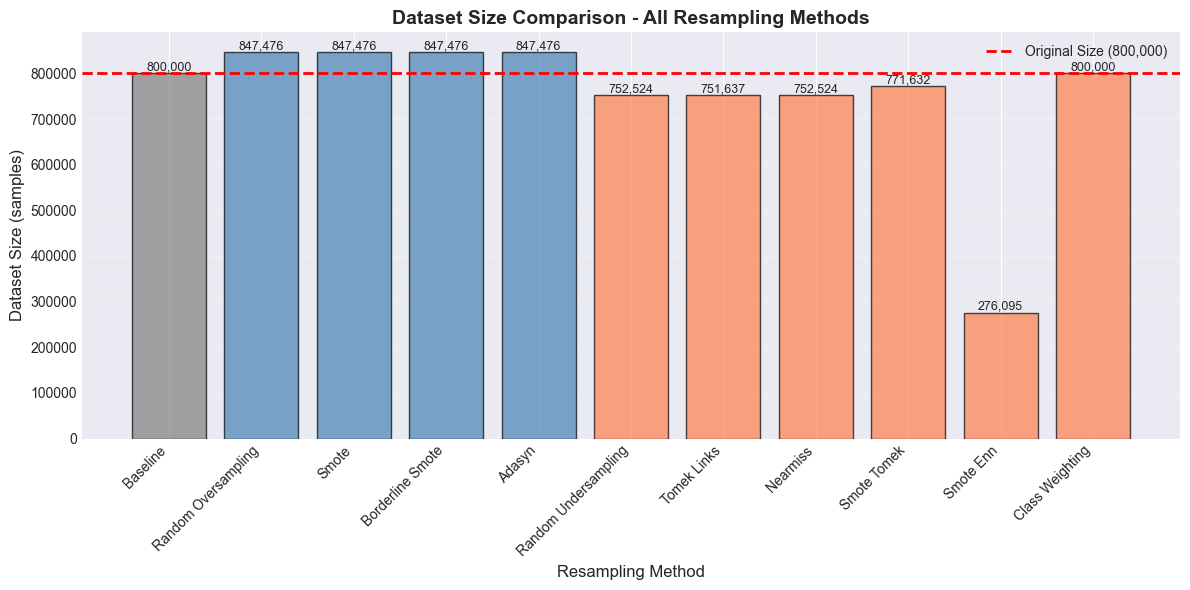

In [20]:
# Cell 16: Visualizing Size Changes
# Creating bar chart showing dataset size changes
# Visualization of how each method affects dataset size

print("Generating dataset size comparison visualization...")

# Creating figure
fig, ax = plt.subplots(figsize=(12, 6))

# Preparing data
methods = comparison_df['Method'].values
sizes = comparison_df['New Size'].values
colors = ['gray' if m == 'Baseline' else 'steelblue' if sizes[i] > baseline_stats['n_samples'] 
          else 'coral' for i, m in enumerate(methods)]

# Creating bar chart
bars = ax.bar(methods, sizes, color=colors, alpha=0.7, edgecolor='black')

# Adding baseline reference line
ax.axhline(y=baseline_stats['n_samples'], color='red', linestyle='--', 
           linewidth=2, label=f"Original Size ({baseline_stats['n_samples']:,})")

# Formatting
ax.set_xlabel('Resampling Method', fontsize=12)
ax.set_ylabel('Dataset Size (samples)', fontsize=12)
ax.set_title('Dataset Size Comparison - All Resampling Methods', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Rotating x-axis labels
plt.xticks(rotation=45, ha='right')

# Adding value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Saving
size_plot_path = FIGURE_OUTPUT / 'resampling_size_comparison.png'
plt.savefig(size_plot_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Size comparison saved to {size_plot_path}")

plt.show()

Generating computational cost comparison...
Time comparison saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\resampling_time_comparison.png


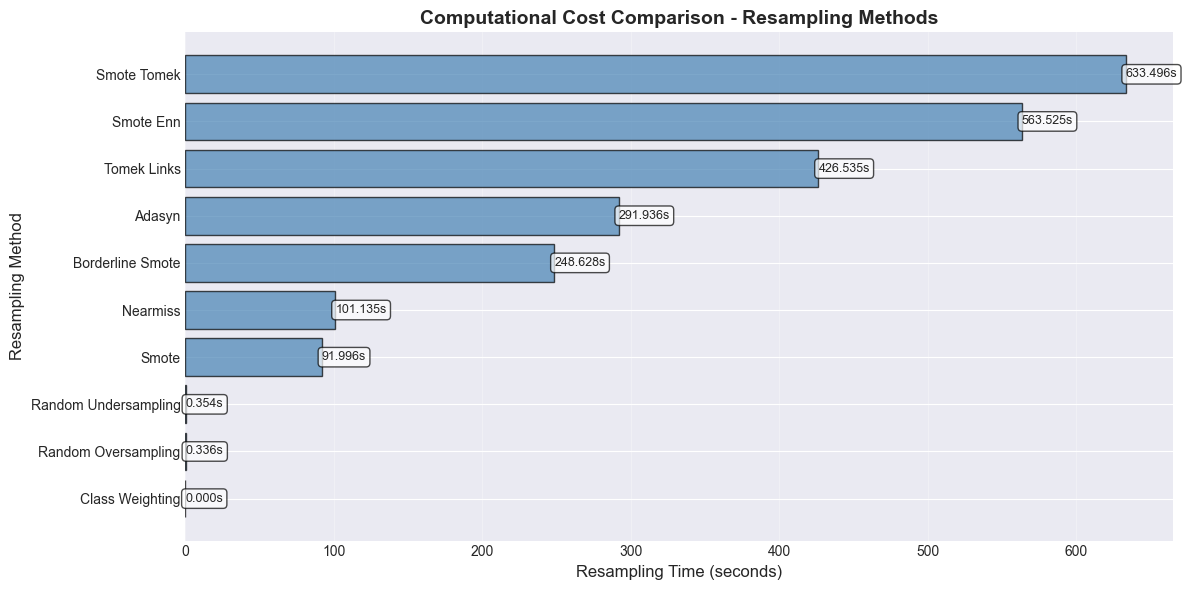

In [21]:
# Cell 17: Visualizing Computational Cost
# Comparing resampling time across methods
# Bar chart showing time required for each method

print("Generating computational cost comparison...")

# Creating figure
fig, ax = plt.subplots(figsize=(12, 6))

# Preparing data (excluding baseline with 0 time)
time_df = comparison_df[comparison_df['Method'] != 'Baseline'].copy()
time_df = time_df.sort_values('Time (seconds)')

methods_time = time_df['Method'].values
times = time_df['Time (seconds)'].values

# Creating bar chart
bars = ax.barh(methods_time, times, color='steelblue', alpha=0.7, edgecolor='black')

# Formatting
ax.set_xlabel('Resampling Time (seconds)', fontsize=12)
ax.set_ylabel('Resampling Method', fontsize=12)
ax.set_title('Computational Cost Comparison - Resampling Methods', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Adding value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f'{width:.3f}s',
            ha='left', va='center', fontsize=9, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()

# Saving
time_plot_path = FIGURE_OUTPUT / 'resampling_time_comparison.png'
plt.savefig(time_plot_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Time comparison saved to {time_plot_path}")

plt.show()

Generating balance achievement visualization...
Balance comparison saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\figures\resampling_balance_comparison.png


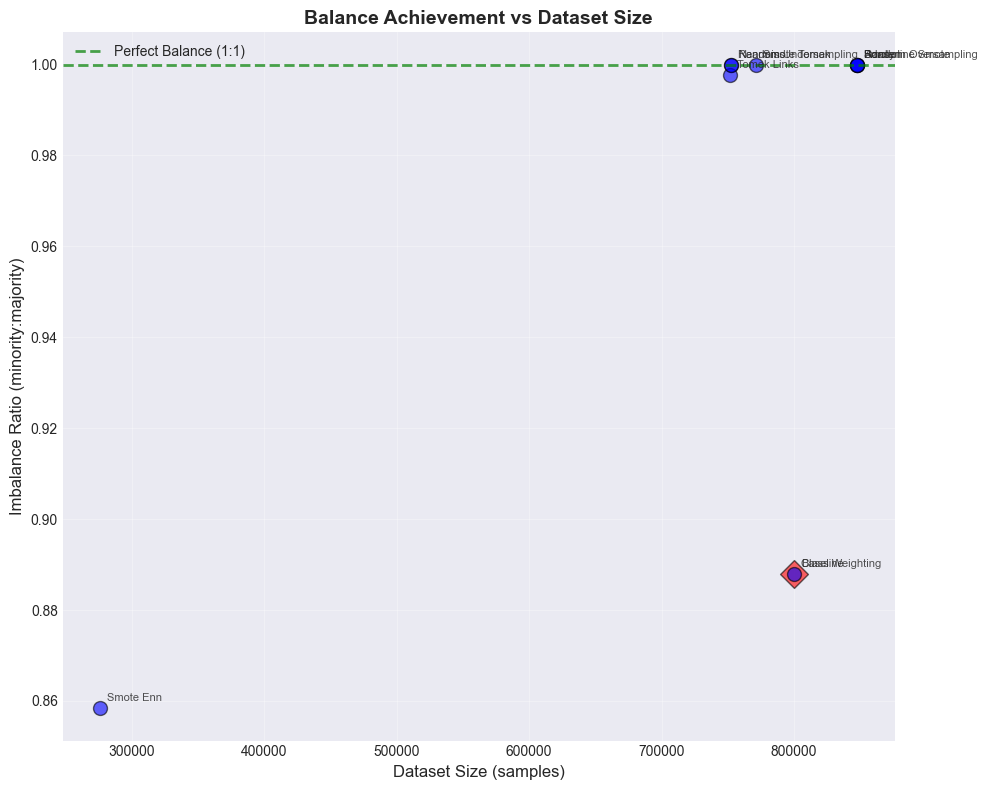

In [22]:
# Cell 18: Visualizing Balance Achievement
# Showing how well each method balances classes
# Scatter plot of imbalance ratio vs dataset size

print("Generating balance achievement visualization...")

# Creating figure
fig, ax = plt.subplots(figsize=(10, 8))

# Preparing data
sizes_plot = comparison_df['New Size'].values
ratios = comparison_df['Imbalance Ratio'].values
methods_plot = comparison_df['Method'].values

# Creating scatter plot with labels
for i, method in enumerate(methods_plot):
    color = 'red' if method == 'Baseline' else 'blue'
    marker = 'D' if method == 'Baseline' else 'o'
    size = 200 if method == 'Baseline' else 100
    
    ax.scatter(sizes_plot[i], ratios[i], s=size, c=color, 
              alpha=0.6, edgecolors='black', marker=marker)
    
    # Adding labels
    ax.annotate(method, (sizes_plot[i], ratios[i]), 
               xytext=(5, 5), textcoords='offset points',
               fontsize=8, alpha=0.8)

# Adding perfect balance line
ax.axhline(y=1.0, color='green', linestyle='--', linewidth=2, 
          label='Perfect Balance (1:1)', alpha=0.7)

# Formatting
ax.set_xlabel('Dataset Size (samples)', fontsize=12)
ax.set_ylabel('Imbalance Ratio (minority:majority)', fontsize=12)
ax.set_title('Balance Achievement vs Dataset Size', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Saving
balance_plot_path = FIGURE_OUTPUT / 'resampling_balance_comparison.png'
plt.savefig(balance_plot_path, dpi=DPI_VALUE, bbox_inches='tight')
print(f"Balance comparison saved to {balance_plot_path}")

plt.show()

In [23]:
# Cell 19: Analyzing Resampling Strategies
# Purpose: Categorizing methods and providing strategic recommendations
# Output: Strategy analysis and use case recommendations

print("="*70)
print("RESAMPLING STRATEGY ANALYSIS")
print("="*70)

# Categorizing methods by approach
oversampling_methods = ['Random Oversampling', 'Smote', 'Borderline Smote', 'Adasyn']
undersampling_methods = ['Random Undersampling', 'Tomek Links', 'Nearmiss']
combination_methods = ['Smote Tomek', 'Smote Enn']
algorithmic_methods = ['Class Weighting']

print("\nMethod Categories:")
print("\n1. Oversampling (Increase Minority):")
for method in oversampling_methods:
    stats = comparison_df[comparison_df['Method'] == method]
    if not stats.empty:
        size_change = stats['Size Change'].values[0]
        time_cost = stats['Time (seconds)'].values[0]
        print(f"   - {method}: +{size_change:,} samples ({time_cost:.3f}s)")

print("\n2. Undersampling (Reduce Majority):")
for method in undersampling_methods:
    stats = comparison_df[comparison_df['Method'] == method]
    if not stats.empty:
        size_change = stats['Size Change'].values[0]
        time_cost = stats['Time (seconds)'].values[0]
        print(f"   - {method}: {size_change:,} samples ({time_cost:.3f}s)")

print("\n3. Combination (Hybrid Approach):")
for method in combination_methods:
    stats = comparison_df[comparison_df['Method'] == method]
    if not stats.empty:
        size_change = stats['Size Change'].values[0]
        time_cost = stats['Time (seconds)'].values[0]
        print(f"   - {method}: {size_change:+,} samples ({time_cost:.3f}s)")

print("\n4. Algorithm-Level:")
print("   - Class Weighting: No data change (0.000s)")

# Identifying fastest and slowest
fastest_method = comparison_df[comparison_df['Method'] != 'Baseline'].nsmallest(1, 'Time (seconds)')
slowest_method = comparison_df[comparison_df['Method'] != 'Baseline'].nlargest(1, 'Time (seconds)')

print(f"\nComputational Efficiency:")
print(f"  Fastest: {fastest_method['Method'].values[0]} ({fastest_method['Time (seconds)'].values[0]:.3f}s)")
print(f"  Slowest: {slowest_method['Method'].values[0]} ({slowest_method['Time (seconds)'].values[0]:.3f}s)")
print(f"  Speed Range: {slowest_method['Time (seconds)'].values[0] / fastest_method['Time (seconds)'].values[0]:.1f}x")

# Identifying most balanced
best_balanced = comparison_df[comparison_df['Method'] != 'Baseline'].iloc[(comparison_df[comparison_df['Method'] != 'Baseline']['Imbalance Ratio'] - 1.0).abs().argsort()[:1]]

print(f"\nBalance Achievement:")
print(f"  Most Balanced: {best_balanced['Method'].values[0]} (Ratio: {best_balanced['Imbalance Ratio'].values[0]:.3f}:1)")
print(f"  Original: Baseline (Ratio: {baseline_stats['imbalance_ratio']:.3f}:1)")

RESAMPLING STRATEGY ANALYSIS

Method Categories:

1. Oversampling (Increase Minority):
   - Random Oversampling: +47,476 samples (0.336s)
   - Smote: +47,476 samples (91.996s)
   - Borderline Smote: +47,476 samples (248.628s)
   - Adasyn: +47,476 samples (291.936s)

2. Undersampling (Reduce Majority):
   - Random Undersampling: -47,476 samples (0.354s)
   - Tomek Links: -48,363 samples (426.535s)
   - Nearmiss: -47,476 samples (101.135s)

3. Combination (Hybrid Approach):
   - Smote Tomek: -28,368 samples (633.496s)
   - Smote Enn: -523,905 samples (563.525s)

4. Algorithm-Level:
   - Class Weighting: No data change (0.000s)

Computational Efficiency:
  Fastest: Class Weighting (0.000s)
  Slowest: Smote Tomek (633.496s)
  Speed Range: infx

Balance Achievement:
  Most Balanced: Random Oversampling (Ratio: 1.000:1)
  Original: Baseline (Ratio: 0.888:1)


In [24]:
# Cell 20: Generating Recommendations
# Providing practical recommendations for each method
# Use case recommendations and method selection guide

print("="*70)
print("METHOD RECOMMENDATIONS")
print("="*70)

print("\nWhen to Use Each Method:")

print("\n1. SMOTE (Most Popular)")
print("   Use When:")
print("     - Need synthetic samples with good generalization")
print("     - Mild to moderate imbalance")
print("     - Sufficient computational resources")
print("   Avoid When:")
print("     - Extreme noise in data")
print("     - Very high-dimensional data")

print("\n2. Random Oversampling")
print("   Use When:")
print("     - Quick baseline needed")
print("     - Limited computational budget")
print("     - Want exact duplicate samples")
print("   Avoid When:")
print("     - Overfitting is a concern")

print("\n3. Borderline-SMOTE")
print("   Use When:")
print("     - Decision boundary is critical")
print("     - Want focused synthetic samples")
print("     - SMOTE results are not satisfactory")

print("\n4. ADASYN")
print("   Use When:")
print("     - Adaptive density needed")
print("     - Harder regions need more samples")
print("     - Similar performance to SMOTE expected")

print("\n5. Random Undersampling")
print("   Use When:")
print("     - Very large majority class")
print("     - Fast training needed")
print("     - Can afford to lose information")
print("   Avoid When:")
print("     - Limited data available")
print("     - All samples are valuable")

print("\n6. Tomek Links")
print("   Use When:")
print("     - Need boundary cleaning")
print("     - Noisy samples suspected")
print("     - Minimal size reduction acceptable")

print("\n7. NearMiss")
print("   Use When:")
print("     - Intelligent undersampling needed")
print("     - Want to keep informative samples")
print("     - Computational cost acceptable")

print("\n8. SMOTE + Tomek")
print("   Use When:")
print("     - Want best of both worlds")
print("     - Need balanced AND clean data")
print("     - Have computational budget")

print("\n9. SMOTE + ENN")
print("   Use When:")
print("     - Aggressive cleaning needed")
print("     - Misclassified samples problematic")
print("     - Quality over quantity")

print("\n10. Class Weighting")
print("    Use When:")
print("      - No data modification desired")
print("      - Model supports sample weights")
print("      - Simplest approach preferred")
print("      - Baseline comparison needed")

METHOD RECOMMENDATIONS

When to Use Each Method:

1. SMOTE (Most Popular)
   Use When:
     - Need synthetic samples with good generalization
     - Mild to moderate imbalance
     - Sufficient computational resources
   Avoid When:
     - Extreme noise in data
     - Very high-dimensional data

2. Random Oversampling
   Use When:
     - Quick baseline needed
     - Limited computational budget
     - Want exact duplicate samples
   Avoid When:
     - Overfitting is a concern

3. Borderline-SMOTE
   Use When:
     - Decision boundary is critical
     - Want focused synthetic samples
     - SMOTE results are not satisfactory

4. ADASYN
   Use When:
     - Adaptive density needed
     - Harder regions need more samples
     - Similar performance to SMOTE expected

5. Random Undersampling
   Use When:
     - Very large majority class
     - Fast training needed
     - Can afford to lose information
   Avoid When:
     - Limited data available
     - All samples are valuable

6. Tomek Link

In [25]:
# Cell 21: Save All Resampling Statistics
# Persisting statistics for use in ML Experiments
# JSON file with all resampling statistics

print("="*70)
print("SAVING RESAMPLING STATISTICS")
print("="*70)

import json

# Preparing statistics dictionary
all_stats = {}
for method_name, results in resampling_results.items():
    stats = results['stats'].copy()
    
    # Converting numpy types to Python types for JSON
    all_stats[method_name] = {
        k: float(v) if isinstance(v, (np.floating, np.integer)) else v
        for k, v in stats.items()
    }
    
    # Adding class weights if available
    if 'weights' in results:
        all_stats[method_name]['weights'] = results['weights']

# Saving to JSON
stats_path = METRIC_OUTPUT / 'resampling' / 'resampling_statistics.json'
stats_path.parent.mkdir(parents=True, exist_ok=True)

with open(stats_path, 'w', encoding='utf-8') as f:
    json.dump(all_stats, f, indent=4)

print(f"Resampling statistics saved to {stats_path}")

# Saving comparison table
comparison_df.to_csv(TABLE_OUTPUT / 'resampling_comparison.csv', index=False)
print(f"Comparison table saved to {TABLE_OUTPUT / 'resampling_comparison.csv'}")

print("\nAll resampling data saved successfully")

SAVING RESAMPLING STATISTICS
Resampling statistics saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\metrics\resampling\resampling_statistics.json
Comparison table saved to C:\Users\Ashutosh\Documents\Projects\beyond-smote-evaluation\results\tables\resampling_comparison.csv

All resampling data saved successfully


In [27]:
# Cell 22: Verifying Saved Datasets
# Confirming all resampled datasets are saved correctly
# Output: List of saved files with sizes

print("="*70)
print("VERIFYING SAVED DATASETS")
print("="*70)

# Listing all saved resampled datasets
resampled_files = list(RESAMPLED_DIR.glob('*.csv'))

print(f"\nTotal Resampled Datasets: {len(resampled_files)}")
print("\nSaved Files:")

for file_path in sorted(resampled_files):
    file_size = file_path.stat().st_size / (1024 * 1024)  # Converting to MB
    print(f"  - {file_path.name}: {file_size:.2f} MB")

# Verifying all methods are saved
expected_methods = list(resampling_results.keys())
saved_methods = [f.stem.replace('higgs_', '').replace('_resampled', '') 
                 for f in resampled_files]

print(f"\nExpected Methods: {len(expected_methods)}")
print(f"Saved Methods: {len(saved_methods)}")

# Class weighting doesn't save a file (algorithm-level only)
expected_data_methods = [m for m in expected_methods if m != 'class_weighting']

missing = set(expected_data_methods) - set(saved_methods)
if missing:
    print(f"\nMissing Methods: {missing}")
else:
    print("\nAll resampling methods saved successfully!")
    print(f"   Note: 'class_weighting' doesn't save data (algorithm-level only)")

# Displaying total storage used
total_size = sum(f.stat().st_size for f in resampled_files) / (1024 * 1024)
print(f"\nTotal Storage Used: {total_size:.2f} MB")

VERIFYING SAVED DATASETS

Total Resampled Datasets: 10

Saved Files:
  - higgs_adasyn_resampled.csv: 260.75 MB
  - higgs_baseline_resampled.csv: 237.05 MB
  - higgs_borderline_smote_resampled.csv: 260.80 MB
  - higgs_nearmiss_resampled.csv: 223.26 MB
  - higgs_random_oversampling_resampled.csv: 251.10 MB
  - higgs_random_undersampling_resampled.csv: 222.97 MB
  - higgs_smote_enn_resampled.csv: 87.87 MB
  - higgs_smote_resampled.csv: 260.75 MB
  - higgs_smote_tomek_resampled.csv: 238.23 MB
  - higgs_tomek_links_resampled.csv: 222.68 MB

Expected Methods: 11
Saved Methods: 10

All resampling methods saved successfully!
   Note: 'class_weighting' doesn't save data (algorithm-level only)

Total Storage Used: 2265.46 MB
